# Lecture 10: Dimensionality Reduction  

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2023/24 data science class at the Rudjer Boskovic Institute, and it is available from [github](https://github.com/ivezic/RBI2023/blob/main/notebooks/Lecture10.ipynb).


Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and many others.


##### Resources for this notebook include:
- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 7.  

<a id='toc'></a>

## This notebook includes:


[The curse of dimensionality](#curse) 

[Principal Component Analysis](#PCA)
 
[Comparing PCA, NMF and ICA](#all3)

## The curse of dimensionality <a id='curse'></a>
[Go to top](#toc)

We often need to search for a subset of sources around some point in the multi-dimensional space of measured parameters. When the dimensionality is (relatively) high, we get into (mathematical) trouble called 
** the curse of dimensionality**. For example, fitting and overfitting get worse with ''curse of dimensionality'' (Bellman 1961). 

Think about a hypersphere. Its volume is  given by


$$  V_D(r) = \frac{2r^D\pi^{D/2}}{D\  \Gamma(D/2)}$$

where $\Gamma(z)$ is the complete gamma function ($\Gamma(z+1)=z \Gamma(z)$; $\Gamma(1/2)=\sqrt{\pi}$, $\Gamma(1)=1$), $D$ is the dimension, and $r$ the radius of the sphere:

D=1: $$V_1(r) = 2r$$
D=2: $$V_2(r) = \pi r^2$$
D=3: $$V_3(r) = (4/3)\pi r^3$$
D=4: $$V_4(r) = (1/2)\pi^2 r^4$$
etc.



If you populated a **hypercube** of size $2r$ ($V_{cube}= 2^D \, r^D$) how much data would be enclosed by the **hypersphere**?

$$
          \frac{V_D(r)}{V_{cube}} = \frac{\pi^{D/2} } {2^{D-1} \, D\  \Gamma(D/2)}
$$ 

### As $D$ increases the fractional volume enclosed by the hypersphere goes to 0! 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import ticker
import scipy.special as sp

for D in [1, 2, 3, 4, 5, 10, 20, 30, 100]:
    rat = np.pi**(D/2) / 2**(D-1) / D / sp.gamma(D/2)
    print(D, rat)

1 1.0
2 0.7853981633974483
3 0.5235987755982989
4 0.30842513753404244
5 0.16449340668482265
10 0.00249039457019272
20 2.4611369504941985e-08
30 2.041026339664143e-14
100 1.8681820538375918e-70


In [30]:
def showDsample(D, Ndata):
    x = {}
    for i in range(0, D):
        x[i] = np.random.uniform(low=-1, high=1, size=Ndata)
    distanceSq = 0 
    for i in range(0, D):
        distanceSq += x[i]**2
    inSphere = distanceSq[distanceSq<1.0]
    print('D=', D,'sample:', len(distanceSq), 'in unit sphere:', len(inSphere))
    print('mean distance squared:', np.mean(distanceSq), 'D/3=', D/3)
    print('std. dev. distance squared:', np.std(distanceSq), 'sqrt(4*D/45)=', np.sqrt(4*D/45))
    print('max distance squared:', np.max(distanceSq), 'D=', D)

In [31]:
showDsample(10, 1000000)

D= 10 sample: 1000000 in unit sphere: 2500
mean distance squared: 3.33358414373636 D/3= 3.3333333333333335
std. dev. distance squared: 0.9426786455431965 sqrt(4*D/45)= 0.9428090415820634
max distance squared: 7.9018999861062165 D= 10


In [32]:
showDsample(30, 1000000)

D= 30 sample: 1000000 in unit sphere: 0
mean distance squared: 9.998421311328629 D/3= 10.0
std. dev. distance squared: 1.6353636417876012 sqrt(4*D/45)= 1.632993161855452
max distance squared: 18.369360992244193 D= 30


### For large D, according to the central limit theorem, the distribution of distance squared from the origin is normal: N($\mu=D/3$, $\sigma = 4D/45$). Also, the maximum value is D. 

### In other words, for high D most data points are found in a relatively thin hyper-spherical shell.

### For example: the SDSS comprises a sample of 357 million sources. 
- each source has 448 measured attributes
- selecting just 30 (e.g., magnitude, size..) and normalizing the data range $-1$ to $1$

The probability of having even one of the 357 million sources reside within a unit hypersphere is about 1 in a million.

### Solution: dimensionality reduction!

## Principal Component Analysis <a id='PCA'></a>
[Go to top](#toc)


![](figures/2DgaussPCA.png)


Points are  correlated along a particular direction which doesn't align with the initial choice of axes. 
* we should rotate our axes to align with this correlation. 
* rotation preserves the relative ordering of data

Choose  rotation to maximize the ability to discriminate between the data points
*   first axis, or <u>principal component</u>, is direction of maximal variance
*   second principal component is orthogonal to the first component and maximizes the residual variance 

## In 2D:

![](figures/2Drotation.png)

In the following example a distribution of points drawn from a bivariate Gaussian and centered on the
origin of $x$ and $y$. 
PCA defines a rotation such that the new axes ($x’$ and $y’$) are aligned along the directions of maximal 
variance (the principal components) with zero covariance. This is equivalent to minimizing the square of 
the perpendicular distances between the points and the principal components.


In [4]:
np.random.seed(42)
r = 0.9

sigma1 = 0.25
sigma2 = 0.08
rotation = np.pi / 6
s = np.sin(rotation)
c = np.cos(rotation)

X = np.random.normal(0, [sigma1, sigma2], size=(100, 2)).T
R = np.array([[c, -s],
              [s, c]])
X = np.dot(R, X)

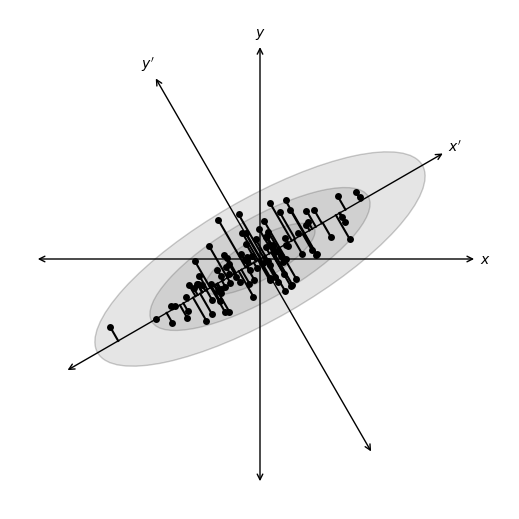

In [5]:
#------------------------------------------------------------
# Plot the diagram
fig = plt.figure(figsize=(5, 5), facecolor='w')
ax = plt.axes((0, 0, 1, 1), xticks=[], yticks=[], frameon=False)

# draw axes
ax.annotate(r'$x$', (-r, 0), (r, 0),
            ha='center', va='center',
            arrowprops=dict(arrowstyle='<->', color='k', lw=1))
ax.annotate(r'$y$', (0, -r), (0, r),
            ha='center', va='center',
            arrowprops=dict(arrowstyle='<->', color='k', lw=1))

# draw rotated axes
ax.annotate(r'$x^\prime$', (-r * c, -r * s), (r * c, r * s),
            ha='center', va='center',
            arrowprops=dict(color='k', arrowstyle='<->', lw=1))
ax.annotate(r'$y^\prime$', (r * s, -r * c), (-r * s, r * c),
            ha='center', va='center',
            arrowprops=dict(color='k', arrowstyle='<->', lw=1))

# scatter points
ax.scatter(X[0], X[1], s=25, lw=0, c='k', zorder=2)

# draw lines
vnorm = np.array([s, -c])
for v in (X.T):
    d = np.dot(v, vnorm)
    v1 = v - d * vnorm
    ax.plot([v[0], v1[0]], [v[1], v1[1]], '-k')

# draw ellipses
for sigma in (1, 2, 3):
    ax.add_patch(Ellipse((0, 0), 2 * sigma * sigma1, 2 * sigma * sigma2,
                         rotation * 180. / np.pi,
                         ec='k', fc='gray', alpha=0.2, zorder=1))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

plt.show()

### For those who want mathematical background: the derivation of principal component analyses for arbitrary dimensionality and sample size

Set of data $X$: $N$ observations by $K$ measurements

Center data by subtracting the mean 

The covariance is

$$ C_X=\frac{1}{N-1}X^TX,$$

We want a projection, $R$,  aligned with the directions of maximal variance ($Y= X R$) with covariance 

$$C_{Y} = R^T X^T X R = R^T C_X R$$

Derive  principal component by maximizing its variance (using Lagrange multipliers and constraint)

$$\phi(r_1,\lambda_1) = r_1^TC_X r_1 - \lambda_1(r_1^Tr_1-1)$$

derivative of $\phi(r_1,\lambda)$ with respect to $r_1$ set to 0

$$C_X \, r_1 - \lambda_1 \, r_1 = 0$$

$\lambda_1$ is the root of the equation $\det(C_X -
\lambda_1 {\bf I})=0$ and the largest eigenvalue

$$\lambda_1 =  r_1^T C_X r_1$$

Other  principal components  derived by
applying additional constraint that components are uncorrelated (e.g., $r^T_2 C_X r_1 = 0$).

#### Singular value decomposition (SVD)
Common approach is eigenvalue decomposition of the covariance or correlation matrix,
or singular value decomposition (SVD) of the data matrix

$$U \Sigma V^T = \frac{1}{\sqrt{N - 1}} X$$

columns of $U$ are  _left-singular vectors_

columns of $V$ are the _right-singular vectors_

The columns of $U$ and $V$ form orthonormal bases ($U^TU = V^TV = I$)

Covariance matrix is

$$
  C_X = \left[\frac{1}{\sqrt{N - 1}}X\right]^T \left[\frac{1}{\sqrt{N - 1}}X\right]\nonumber\\
      = V \Sigma U^T U \Sigma V^T\nonumber\\
      = V \Sigma^2 V^T.
$$

right singular vectors $V$ are the principal components so principal from the SVD of $X$ dont need $C_X$.

## bottom line:

Thus we have three equivalent ways of computing the principal components R and the eigenvalues $C_X$: the SVD of $X$, the eigenvalue decomposition of $C_X$, or the eigenvalue decomposition of $M_X$. The optimal procedure will depend on the relationship between the data size N and the dimensionality K. If N ≫ K, then using the eigenvalue decomposition of the K × K covariance matrix CX will in general be more efficient. If K ≫ N , then using the N × N correlation matrix MX will be more efficient. In the intermediate case, direct computation of the SVD of X will be the most efficient route.

#### Application of PCA

For our astronomy use case, we are using the SDSS spectroscopic dataset. 
The SDSS spectra come from galaxies at a range of redshifts,
and have sections of unreliable or missing data due to sky absorption, cosmic rays, bad detector pixels,
or other effects. AstroML provides a set of spectra which have been moved to rest frame, corrected
for masking using an iterative PCA reconstruction technique, and resampled to 1000 common wavelength bins. 

**Therefore, we are trying to reduce the dimensionality of a 1000-dimensional dataset (4000 spectra, see below). How many informative dimensions do we have?**

The spectra can be downloaded using `fetch_sdss_corrected_spectra()`. In the following example we plot
15 of these spectra:

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from astroML.datasets import sdss_corrected_spectra

#----------------------------------------------------------------------
# Use pre-computed PCA to reconstruct spectra
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra_raw = data['spectra']
print('# of spectra:', len(spectra_raw))
spectra_corr = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# select random spectra
np.random.seed(10)
nrows = 5
ncols = 3
ind = np.random.randint(spectra_corr.shape[0], size=nrows * ncols)
spec_sample_raw = spectra_raw[ind]
spec_sample_corr = spectra_corr[ind]

# of spectra: 4000


We show the randomly selected 15 SDSS downloaded spectra with black, and our corrected spectra with blue.

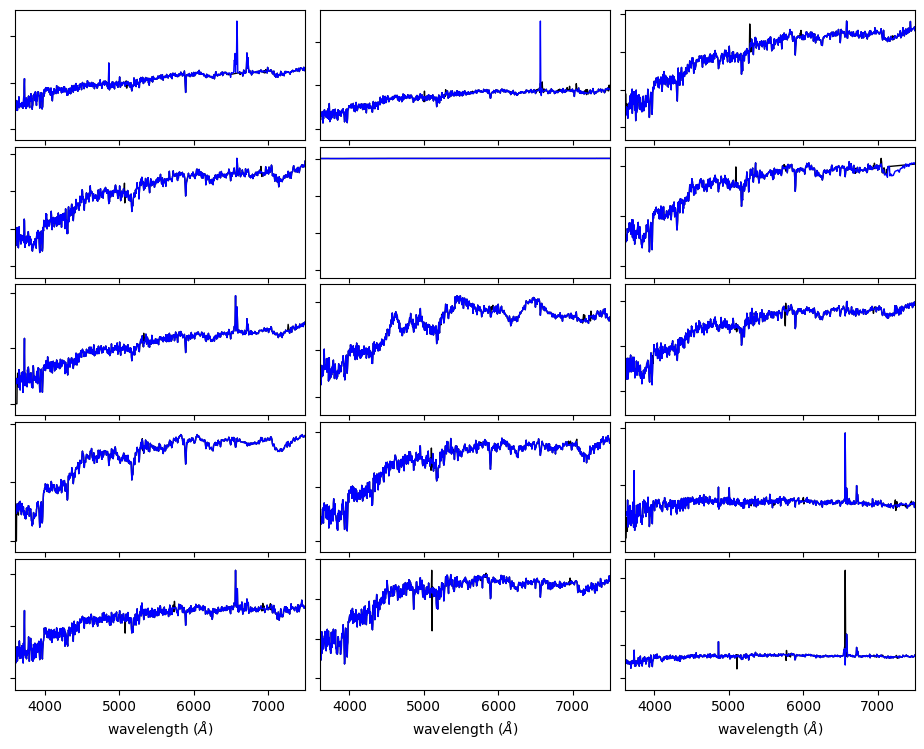

In [7]:
fig = plt.figure(figsize=(10, 8))

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

for i in range(ncols):
    for j in range(nrows):
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(wavelengths, spec_sample_raw[ncols * j + i], '-k', lw=1)
        ax.plot(wavelengths, spec_sample_corr[ncols * j + i], '-k', lw=1, c='blue')               
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')

        ylim = ax.get_ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + dy)
        ax.set_xlim(3600, 7500)

plt.show()

### PCA Reconstruction of a spectrum

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

$$  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),$$

**Truncating** this expansion (i.e., $r<R$)

$$
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
$$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- projecting each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

In the following example, the input spectrum is shown in gray,
and the partial reconstruction for progressively more terms is shown in black. 
The top panel shows only the mean of the set of spectra. By the time 20 PCA components are added,
the reconstruction is very close to the input, as indicated by the expected total variance of 94%.

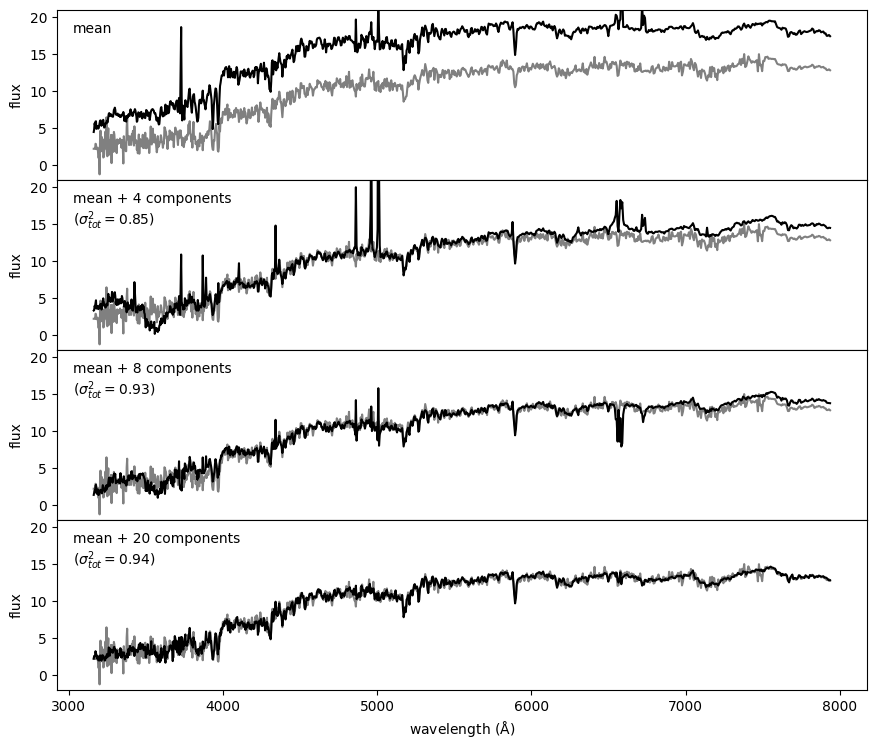

In [8]:
#------------------------------------------------------------
# Compute PCA components

# Eigenvalues can be computed using PCA as in the commented code below:
#   just 4 lines using sklearn code: 
# from sklearn.decomposition import PCA
# pca = PCA()
# pca.fit(spectra_corr)
# evals = pca.explained_variance_ratio_
# evals_cs = evals.cumsum()

# a little data-specific hack: 
#  because the spectra have been reconstructed from masked values, this
#  is not exactly correct in this case: we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra_corr.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra_corr[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

### Eigenvalues

The eigenvalues for the PCA decomposition of the SDSS spectra described in the previous section. The top panel
shows the decrease in eigenvalue as a function of the number of eigenvectors, with a break in the distribution
at ten eigenvectors. The lower panel shows the cumulative sum of eigenvalues normalized to unity. 
94% of the variance in the SDSS spectra can be captured using the first ten eigenvectors.

## This plot is often called the "scree" plot ("scree" is "usolina" in Croatian).

![](figures/usolina.png)

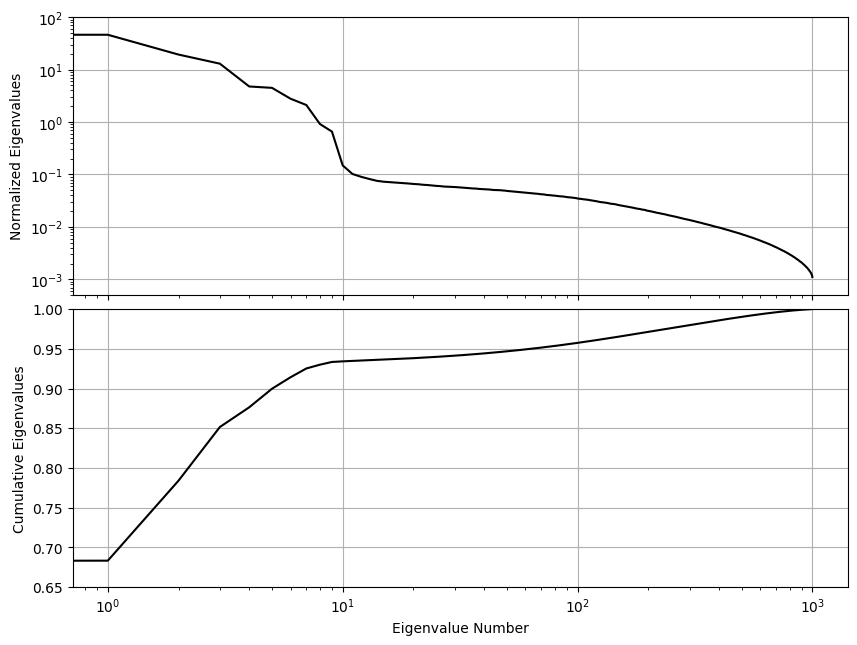

In [9]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='k')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='k')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
ax.set_ylim(0.65, 1.00)

plt.show()

### PCA with missing data

Observed spectrum, $x^o$ is the true spectrum, ${x}$ plus a wavelength-dependent weight, ${w}$.  

Weight is zero where data are missing and $1/{\sigma}^2$ for rest

Minimizing the quadratic deviation between  ${x}^o$ truncated reconstruction, $\sum_i \theta_i {e}_i$
and solving for $\theta_i$ gives

$$
	\sum_k \theta_i {w}(k) {e}_i(k) {e}_j(k) =
	\sum_k {w}(k) {x}^o(k) {e}_j(k),
$$

If $M_{ij} = \sum_k {w}(k) {e}_i(k) {e}_j(k)$ and $F_i = \sum_k {w}(k) {x}^o(k) {e}_i(k)$ then 

$$
	\theta_i = \sum_j M_{ij}^{-1} F_{j},
$$

- $F_j$ are  coefficients derived from  gappy data
- $M_{ij}^{-1}$ shows how correlated  eigenvectors are over the missing regions.

An estimate of the uncertainty on the
reconstruction coefficients is given by

$$
%Cov(\theta_i,\theta_j) = \frac{1}{N}M_{ij}^{-1}
{\rm Cov}(\theta_i,\theta_j) = M_{ij}^{-1}.
$$

Accuracy of this reconstruction will depend on the distribution of
the gaps within the data vector.

The principal component vectors defined for the SDSS spectra can be used to interpolate across or reconstruct
missing data. Examples of three masked spectral regions are shown comparing the reconstruction of the input 
spectrum (black line) using the mean and the first ten eigenspectra (blue line) The gray bands represent the 
masked region of the spectrum.

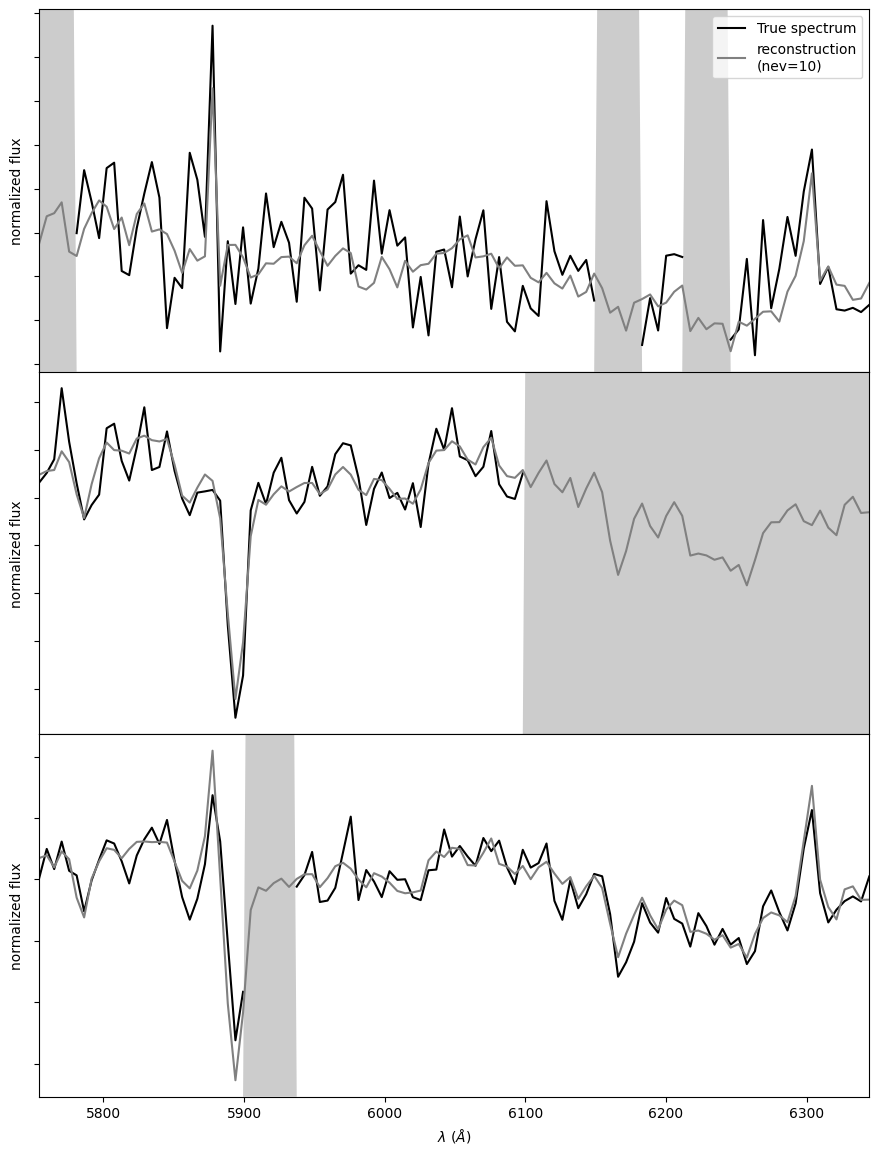

In [10]:
evecs = data['evecs']
mu = data['mu']
norms = data['norms']
mask = data['mask']

#------------------------------------------------------------
# plot the results
i_plot = ((wavelengths > 5750) & (wavelengths < 6350))
wavelength = wavelengths[i_plot]

specnums = [20, 8, 9]
subplots = [311, 312, 313]

fig = plt.figure(figsize=(10, 12.5))
fig.subplots_adjust(left=0.09, bottom=0.08, hspace=0, right=0.92, top=0.95)

for subplot, i in zip(subplots, specnums):
    ax = fig.add_subplot(subplot)

    # compute eigen-coefficients
    spectra_i_centered = spectra_corr[i] / norms[i] - mu
    coeffs = np.dot(spectra_i_centered, evecs.T)

    # blank out masked regions
    spectra_i = spectra_corr[i]
    mask_i = mask[i]
    spectra_i[mask_i] = np.nan

    # plot the raw masked spectrum
    ax.plot(wavelength, spectra_i[i_plot], '-', color='k',
            label='True spectrum', lw=1.5)

    # plot two levels of reconstruction
    for nev in [10]:
        if nev == 0:
            label = 'mean'
        else:
            label = 'reconstruction\n(nev=%i)' % nev
        spectra_i_recons = norms[i] * (mu + np.dot(coeffs[:nev], evecs[:nev]))
        ax.plot(wavelength, spectra_i_recons[i_plot], label=label, color='grey')

    # plot shaded background in masked region
    ylim = ax.get_ylim()
    mask_shade = ylim[0] + mask[i][i_plot].astype(float) * ylim[1]
    plt.fill(np.concatenate([wavelength[:1], wavelength, wavelength[-1:]]),
             np.concatenate([[ylim[0]], mask_shade, [ylim[0]]]),
             lw=0, fc='k', alpha=0.2)

    ax.set_xlim(wavelength[0], wavelength[-1])
    ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    if subplot == 311:
        ax.legend(loc=1)

    ax.set_xlabel('$\lambda\ (\AA)$')
    ax.set_ylabel('normalized flux')

plt.show()

## For PCA with noisy data, see Jake's implementation at
https://nbviewer.org/github/jakevdp/wpca/tree/master/

and an example of using it in

https://nbviewer.org/github/jakevdp/wpca/blob/master/WPCA-Example.ipynb


## Comparing PCA, NMF and ICA  <a id='all3'></a>
[Go to top](#toc)

### Nonnegative Matrix Factorization (NMF)

Attempts to address the fact that PCA eigencomponents can be negative even when we 
have physical reasons (a priori knowledge) to expect them to be non-negative.

Assumes that the data matrix $X$ is a product of two positive matrices, $X=Y*W$.

Solved iteratively for $Y$ and $W$ by minimizing the reconstruction error $||(X-WY)^2||$

Nonnegative matrix factorization (NMF) applies positivity constraint.

In [11]:
from sklearn.decomposition import NMF

X = np.random.random((100, 3))  # 100 points in 3 dims, all positive
nmf = NMF(n_components=3)  # setting n_components is optional
nmf.fit(X)
proj = nmf.transform(X)  # project to 3 dimensions

comp = nmf.components_  # 3 x 10 array of components
err = nmf.reconstruction_err_  # how well 3 components captures data

### Independent component analysis

Also known as the “coctail party problem”, it assumes that the signal is a linear combination of components.

PCA: Assumes that the components are **orthogonal and capture the maximum variance** in the data. It does **not** assume statistical independence between components. 

ICA: Assumes that the components are **statistically independent**. It does **not** assume orthogonality, and the components need **not** capture the maximum variance.

**Another way of saying this is that PCA helps to compress data while ICA helps to separate data.**

PCA is used for dimensionality reduction, feature extraction, and data visualization. It is effective in capturing the overall structure of the data.

ICA is mainly used for blind source separation problems, where the goal is to recover original, independent sources from mixed observations (hence the “coctail party problem”).

In [12]:
from sklearn.decomposition import FastICA

X = np.random.normal(size=(100, 2))  # 100 pts in 2 dims
R = np.random.random((2, 5))  # mixing matrix
X = np.dot(X, R)  # X is now 2D data in 5D space
ica = FastICA(2)  # fit two components

sources = ica.fit_transform(X)
proj = ica.transform(X)  # 100 x 2 projection of data
comp = ica.components_  # the 2 x 5 matrix of indep. components

### Comparing PCA, NMF and ICA

A comparison of the decomposition of SDSS spectra using PCA (left panel), ICA (middle panel) and 
NMF (right panel). The rank of the component increases from top to bottom. For the ICA and PCA 
the first component is the mean spectrum (NMF does not require mean subtraction). All of these 
techniques isolate a common set of spectral features (identifying features associated with the 
continuum and line emission). The ordering of the spectral components is technique dependent.

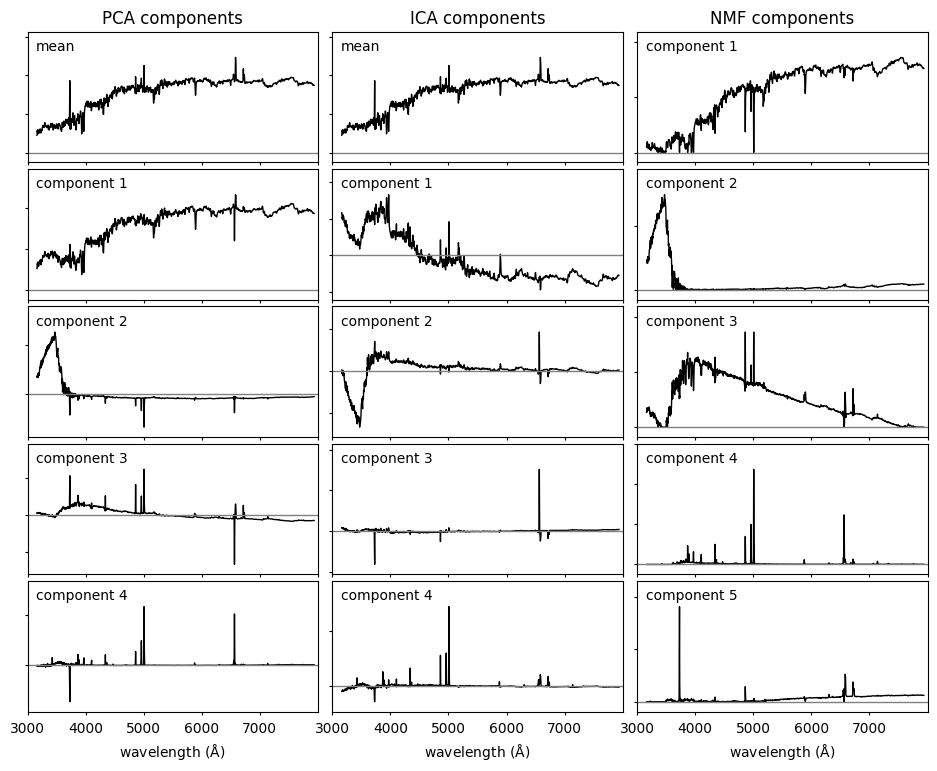

In [13]:
from sklearn.decomposition import NMF, FastICA, PCA

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#----------------------------------------------------------------------
# Compute PCA, ICA, and NMF components
def compute_PCA_ICA_NMF(n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,
                          pca.components_])

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, random_state=0)
    ica.fit(spectra.T)
    ica_comp = np.vstack([spec_mean,
                          ica.transform(spectra.T).T])

    # NMF requires all elements of the input to be greater than zero
    spectra[spectra < 0] = 0
    nmf = NMF(n_components, random_state=0)
    nmf.fit(spectra)
    nmf_comp = nmf.components_

    return pca_comp, ica_comp, nmf_comp

n_components = 5
decompositions = compute_PCA_ICA_NMF(n_components)

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 7999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 8000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)


plt.show()

![](figures/mf1.png)
![](figures/mf2.png)
![](figures/mf3.png)

#### Summary of pracical properties of PCA, NMF, and ICA

The following table is a simple summary of the trade-offs along our axes of
accuracy, interpretability, simplicity, and speed in dimension
reduction methods, expressed in terms of high (H), medium
(M), and low (L) categories.

|Method | Accuracy | Interpretability | Simplicity | Speed |
|-------|----------|------------------|------------|-------|
|Principal component analysis | H | H | H |  H |
|Nonnegative matrix factorization | H | H | M | M|
|Independent component analysis | M | M | L | L |
|Locally linear embedding | H | M | H | H |

#### **NOTE:** it's chapter 7 above, not 9, and it seems that some API's from sklearn changed...

## Local Linear Embedding:

**Step 1: define local geometry**
- local neighborhoods determined from $k$ nearest neighbors.
- for each point calculate weights that reconstruct a point from its $k$ nearest
neighbors
>$
\begin{equation}
  \mathcal{E}_1(W) = \left|X - WX\right|^2
\end{equation}
$
- essentially this is finding the hyperplane that describes the local surface at each point within the data set. 


**Step 2: embed within a lower dimensional space**
- set all $W_{ij}=0$ except when point $j$ is one of the $k$ nearest neighbors of point $i$.  
- $W$ becomes very sparse for $k \ll N$.  
- minimize
>$\begin{equation}
  \mathcal{E}_2(Y) = \left|Y - W Y\right|^2,
\end{equation}
$

with $W$ fixed to find an $N$ by $d$ matrix ($d$ is the new dimensionality)

Step 1 requires a nearest-neighbor search.

Step 2 requires an
eigenvalue decomposition of the matrix $C_W \equiv (I-W)^T(I-W)$,


### let's now compare PCA and LLE performance on SDSS galaxy spectra

@pickle_results: using precomputed results from 'spec_LLE.pkl'


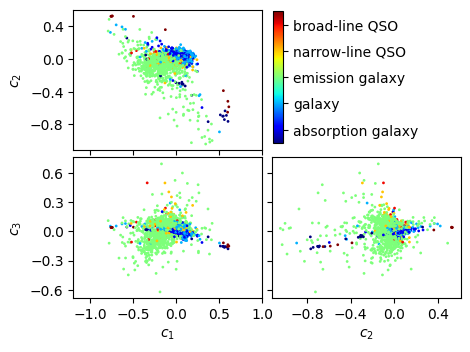

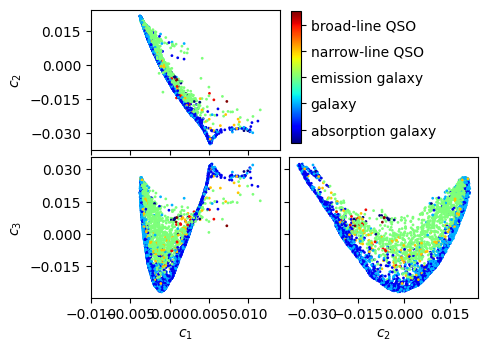

In [14]:
# Author: Jake VanderPlas
# License: BSD
import numpy as np
from matplotlib import pyplot as plt
from sklearn import manifold, neighbors

from astroML.datasets import sdss_corrected_spectra
from astroML.datasets import fetch_sdss_corrected_spectra
from astroML.decorators import pickle_results

#------------------------------------------------------------
# Set up color-map properties
clim = (1.5, 6.5)
cmap = plt.cm.jet 
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']
cticks = [2, 3, 4, 5, 6]
formatter = plt.FuncFormatter(lambda t, *args: cdict[int(np.round(t))])


#------------------------------------------------------------
# Fetch the data; PCA coefficients have been pre-computed
data = fetch_sdss_corrected_spectra()
coeffs_PCA = data['coeffs']
c_PCA = data['lineindex_cln']
spec = sdss_corrected_spectra.reconstruct_spectra(data)
color = data['lineindex_cln']


#------------------------------------------------------------
# Compute the LLE projection; save the results
@pickle_results("spec_LLE.pkl")
def compute_spec_LLE(n_neighbors=10, out_dim=3):
    # Compute the LLE projection
    LLE = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=out_dim,
                                          method='modified',
                                          eigen_solver='dense')
    Y_LLE = LLE.fit_transform(spec)
    print (" - finished LLE projection")

    # remove outliers for the plot
    BT = neighbors.BallTree(Y_LLE)
    dist, ind = BT.query(Y_LLE, n_neighbors)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print (" - removing %i outliers for plot" % flag.sum())

    return Y_LLE[~flag], color[~flag]

coeffs_LLE, c_LLE = compute_spec_LLE(10, 3)


#----------------------------------------------------------------------
# Plot the results:
for (c, coeffs, xlim) in zip([c_PCA, c_LLE],
                             [coeffs_PCA, coeffs_LLE],
                             [(-1.2, 1.0), (-0.01, 0.014)]):
    fig = plt.figure(figsize=(5, 3.75))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # axes for colorbar
    cax = plt.axes([0.525, 0.525, 0.02, 0.35])

    # Create scatter-plots
    scatter_kwargs = dict(s=4, lw=0, edgecolors='none', c=c, cmap=cmap)

    ax1 = plt.subplot(221)
    im1 = ax1.scatter(coeffs[:, 0], coeffs[:, 1], **scatter_kwargs)
    im1.set_clim(clim)
    ax1.set_ylabel('$c_2$')

    ax2 = plt.subplot(223)
    im2 = ax2.scatter(coeffs[:, 0], coeffs[:, 2], **scatter_kwargs)
    im2.set_clim(clim)
    ax2.set_xlabel('$c_1$')
    ax2.set_ylabel('$c_3$')

    ax3 = plt.subplot(224)
    im3 = ax3.scatter(coeffs[:, 1], coeffs[:, 2], **scatter_kwargs)
    im3.set_clim(clim)
    ax3.set_xlabel('$c_2$')

    fig.colorbar(im3, ax=ax3, cax=cax,
                 ticks=cticks,
                 format=formatter)

    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax3.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)

    for ax in (ax1, ax2, ax3):
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()
 